<a href="https://colab.research.google.com/github/Bmiami988/News-Article-Clustering/blob/main/News_Article_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NEWS ARTICLE CLUSTERING PROJECT**

This project performs unsupervised text clustering on my sample BBC News dataset to group articles into thematic clusters based on their content. It combines several NLP and machine learning techniques to achieve this goal, including:



1.  Data loading and validation to ensure quality input
2.  Text preprocessing (cleaning, lemmatization, stopword removal)
3.  TF-IDF vectorization to transform text into numerical features
4.  Clustering algorithms: K-Means and Hierarchical Clustering
5.  Evaluation using Silhouette Score and Adjusted Rand Index (when labels are available)
6.  Visualizations: PCA, t-SNE plots, dendrograms, and cluster composition charts
7.  Cluster labeling by mapping to most frequent true categories and extracting top keywords
8.  Result saving for reporting and downstream analysis


The goal is to explore how unsupervised learning can organize and reveal structure in text data without using predefined labels while still benchmarking against known categories to assess performance.

In [1]:
!pip install faker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 32.4 MB/s eta 0:00:00


# **GENERATE SAMPLE DATA for testing**

In [2]:
import pandas as pd
import numpy as np
from faker import Faker
import random
from datetime import datetime, timedelta

# Initialize faker for realistic text generation
fake = Faker()

# --- Generate BBC News Dataset ---
def generate_bbc_news_dataset(num_articles=1000):
    categories = ['business', 'entertainment', 'politics', 'sport', 'tech']
    articles = []

    for _ in range(num_articles):
        category = random.choice(categories)

        # Generate article content based on category
        if category == 'business':
            title = fake.sentence(nb_words=8,
                ext_word_list=['stocks', 'market', 'economy', 'bank', 'finance'])
            text = fake.paragraph(nb_sentences=10,
                ext_word_list=['investment', 'growth', 'quarterly', 'profit', 'revenue'])

        elif category == 'entertainment':
            title = fake.sentence(nb_words=6,
                ext_word_list=['celebrity', 'film', 'award', 'music', 'premiere'])
            text = fake.paragraph(nb_sentences=8,
                ext_word_list=['actor', 'director', 'performance', 'album', 'release'])

        elif category == 'politics':
            title = fake.sentence(nb_words=7,
                ext_word_list=['government', 'election', 'policy', 'minister', 'vote'])
            text = fake.paragraph(nb_sentences=12,
                ext_word_list=['parliament', 'debate', 'law', 'international', 'agreement'])

        elif category == 'sport':
            title = fake.sentence(nb_words=5,
                ext_word_list=['match', 'championship', 'team', 'player', 'win'])
            text = fake.paragraph(nb_sentences=6,
                ext_word_list=['goal', 'tournament', 'score', 'league', 'season'])

        else:  # tech
            title = fake.sentence(nb_words=6,
                ext_word_list=['smartphone', 'app', 'software', 'AI', 'launch'])
            text = fake.paragraph(nb_sentences=9,
                ext_word_list=['technology', 'update', 'device', 'digital', 'innovation'])


        text = f"By {fake.name()}, BBC News\n\n{text}\n\nRelated topics: {', '.join(fake.words(3))}"

        # generate realistic dates
        date = fake.date_between(start_date='-2y', end_date='today')

        articles.append({
            'title': title,
            'text': text,
            'category': category,
            'date': date,
            'author': fake.name(),
            'url': f"https://www.bbc.com/news/{category}/{fake.uuid4()}"
        })

    return pd.DataFrame(articles)

#generate Stopwords File
def generate_stopwords_file():
    #basic english stopwords
    stopwords = {
        'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",
        "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself',
        'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them',
        'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll",
        'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has',
        'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or',
        'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against',
        'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from',
        'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once',
        'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
        'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than',
        'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now',
        'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn',
        "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn',
        "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't",
        'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"
    }

    #add news-specific stopwords
    news_stopwords = {
        'said', 'says', 'according', 'reported', 'report', 'bbc', 'news', 'mr', 'mrs', 'ms',
        'year', 'years', 'time', 'times', 'new', 'like', 'also', 'first', 'last', 'many',
        'people', 'day', 'days', 'week', 'weeks', 'month', 'months', 'told', 'say', 'saying'
    }

    stopwords.update(news_stopwords)

    #writeto a file
    with open('/content/stopwords.txt', 'w') as f:
        f.write('\n'.join(sorted(stopwords)))

#main execution ---
if __name__ == "__main__":
    print("Generating BBC News dataset...")
    bbc_df = generate_bbc_news_dataset(2000)  #we are generating 2000 articles
    bbc_df.to_csv('/content/bbc_news.csv', index=False)
    print("Generated bbc_news.csv with 2000 articles")

    print("\nGenerating stopwords file...")
    generate_stopwords_file()
    print("Generated stopwords.txt with 200+ stopwords")

    print("\nSample data:")
    print(bbc_df.head(3))
    print("\nFirst 20 stopwords:")
    with open('stopwords.txt') as f:
        print('\n'.join(f.readlines()[:20]))

Generating BBC News dataset...
Generated bbc_news.csv with 2000 articles

Generating stopwords file...
Generated stopwords.txt with 200+ stopwords

Sample data:
                                               title  \
0  App smartphone app software smartphone softwar...   
1      Minister minister policy government election.   
2  Minister minister election election vote vote ...   

                                                text  category        date  \
0  By Luke Lowe, BBC News\n\nDevice innovation te...      tech  2025-03-18   
1  By Shane Wheeler, BBC News\n\nInternational ag...  politics  2024-06-04   
2  By Bobby Collins, BBC News\n\nParliament law p...  politics  2024-01-24   

             author                                                url  
0  Carolyn Mcdowell  https://www.bbc.com/news/tech/4a08e03a-548a-4a...  
1       Rita Graham  https://www.bbc.com/news/politics/4c41007c-8db...  
2     Douglas Moore  https://www.bbc.com/news/politics/d1ec67ed-605...  

First 20

# **CONFIGURATION SET UP**

*This cell defines key configuration parameters for my document clustering project using a sample BBC News dataset. It includes file paths, clustering settings, text preprocessing thresholds, and visualization preferences. These constants ensure consistency and make my codebase easier to manage and update.*

In [15]:
import os
from pathlib import Path

# Paths
DATA_PATH = ("/content/bbc_news.csv")
STOPWORDS_PATH = ("/content/stopwords.txt")
RESULTS_DIR = ("/content/results")
os.makedirs(RESULTS_DIR, exist_ok=True)

# Clustering params
NUM_CLUSTERS = 5
MAX_FEATURES = 1000 #for Tfidf
RANDOM_STATE = 42
TEST_SIZE = 0.2

#for text Processing
MIN_DF = 2  # minimum document frequency for words
MAX_DF = 0.95  # maximum document frequency (remove overly common words)

#for visualization
DENDROGRAM_COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
PLOT_DPI = 300  #for saving high-quality figures

print(f"Data path: {DATA_PATH}")
print(f"Stopwords path: {STOPWORDS_PATH}")
print(f"Results directory: {RESULTS_DIR}")
print(f"Number of clusters: {NUM_CLUSTERS}")
print(f"Random state: {RANDOM_STATE}")
print(f"Test size for train-test split: {TEST_SIZE}")
print(f"Minimum document frequency for words: {MIN_DF}")
print(f"Maximum document frequency for words: {MAX_DF}")
print(f"Colors for dendrogram: {DENDROGRAM_COLORS}")


Data path: /content/bbc_news.csv
Stopwords path: /content/stopwords.txt
Results directory: /content/results
Number of clusters: 5
Random state: 42
Test size for train-test split: 0.2
Minimum document frequency for words: 2
Maximum document frequency for words: 0.95
Colors for dendrogram: ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']


# **DATA LOADING & VALIDATION**

*This cell defines a function that loads my sample BBC News dataset and perform basic validation checks. It ensures the dataset is clean by checking for missing values, duplicates, and unexpected categories. Logging is used to provide informative feedback during the loading process, making it easier to debug or audit data quality issues.*

In [9]:
import pandas as pd
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def load_data(validate=True):
    """Load and validate the BBC news dataset"""
    try:
        df = pd.read_csv(DATA_PATH)

        if validate:
            #performing data validation checks
            if df.isnull().sum().any():
                raise ValueError("Data contains missing values")
            if df.duplicated().any():
                logger.warning("Data contains duplicates - consider removing them")

            expected_categories = ['business', 'entertainment', 'politics', 'sport', 'tech']
            if not set(df['category'].unique()).issubset(expected_categories):
                logger.warning("Unexpected categories found in data")

        logger.info(f"Loaded {len(df)} articles. Categories: {df['category'].unique()}")
        return df[['text', 'category']]  #keep only text and true labels

    except FileNotFoundError:
        logger.error(f"Data file not found at {DATA_PATH}")
        raise
    except Exception as e:
        logger.error(f"Error loading data: {str(e)}")
        raise

if __name__ == "__main__":
    data = load_data()
    print(data.head())
    print(data.shape)

    print(data.columns.to_list())

                                                text       category
0  By Luke Lowe, BBC News\n\nDevice innovation te...           tech
1  By Shane Wheeler, BBC News\n\nInternational ag...       politics
2  By Bobby Collins, BBC News\n\nParliament law p...       politics
3  By Roberta Wilson, BBC News\n\nDirector direct...  entertainment
4  By Latasha Simpson, BBC News\n\nDigital device...           tech
(2000, 2)
['text', 'category']


# **TEXT PROCESSING & TF-IDF VECTORIZATION**

*This cell defines a robust pipeline for preparing raw news text for clustering. It includes functions to clean and lemmatize the text, then converts it into TF-IDF feature vectors. The process dynamically adjusts vectorization parameters based on the dataset size and quality. It also loads custom stopwords and ensures graceful handling of common edge cases in real-world text data.*

In [17]:
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

#Let us initialize NLP tools with error handling
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('punkt')
    nltk.download('wordnet')
    nltk.download('omw-1.4')  #This is required for WordNet lemmatization

lemmatizer = WordNetLemmatizer()

def clean_text(text):
    """Enhanced text cleaning pipeline"""
    if not isinstance(text, str):
        return ""

    #to lowercase
    text = text.lower()

    #remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    #remove special characters and numbers
    text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)
    text = re.sub(r'\d+', '', text)

    #remove BBC-specific artifacts
    text = re.sub(r'\bbbc\b', '', text)  #remove 'bbc' as standalone word
    text = re.sub(r'\bnews\b', '', text)  #remove 'news' as standalone word

    #remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def lemmatize_text(text):
    """Tokenize and lemmatize text with error handling"""
    try:
        tokens = word_tokenize(text)
        return ' '.join([lemmatizer.lemmatize(token) for token in tokens])
    except:
        return text  #this falls back to original text if tokenization fails


def tfidf_vectorize(texts, use_lemmatization=True):
    """Robust TF-IDF vectorization that handles edge cases"""
    with open(STOPWORDS_PATH) as f:
        stopwords = list(set(f.read().splitlines()))

    #initial preprocessing
    processed_texts = [clean_text(text) for text in texts]
    if use_lemmatization:
        processed_texts = [lemmatize_text(text) for text in processed_texts]

    #dynamic parameter adjustment based on my dataset size
    n_docs = len(processed_texts)

    #we start with default parameters
    params = {
        'max_features': MAX_FEATURES,
        'stop_words': stopwords,
        'ngram_range': (1, 2),
        'sublinear_tf': True
    }

    #we progressively try more lenient parameters until we get features
    for attempt in range(3):
        try:
            if attempt == 0:
                #first try is our original parameters
                params.update({
                    'min_df': min(2, max(1, int(n_docs * 0.01))),  # At least 1% docs or 2 absolute
                    'max_df': 0.95
                })
            elif attempt == 1:
                #second try is more lenient
                params.update({
                    'min_df': 1,  # Absolute minimum
                    'max_df': 1.0  # Allow all terms
                })
            else:
                #final try is the most lenient possible
                params.update({
                    'min_df': 1,
                    'max_df': 1.0,
                    'stop_words': None  #don't filter any stopwords
                })

            vectorizer = TfidfVectorizer(**params)
            X = vectorizer.fit_transform(processed_texts)

            if X.shape[1] > 0:  #if we got features
                return X, vectorizer

        except ValueError:
            continue

    #if all attempts failed
    raise ValueError(
        "Unable to vectorize text - try less aggressive preprocessing or "
        "review your text data quality"
    )


if __name__ == "__main__":
    test_texts = [
        "BBC News reports on the latest technology developments.",
        "The government announced new policies today.",
        "Sports team wins championship in dramatic finale."
    ]

    tfidf_matrix, vectorizer = tfidf_vectorize(test_texts)
    print("TF-IDF Matrix Shape:", tfidf_matrix.shape)
    print("First 20 Feature Names:", vectorizer.get_feature_names_out()[:20])

TF-IDF Matrix Shape: (3, 25)
First 20 Feature Names: ['announced' 'announced policies' 'championship' 'championship dramatic'
 'developments' 'dramatic' 'dramatic finale' 'finale' 'government'
 'government announced' 'latest' 'latest technology' 'policies'
 'policies today' 'reports' 'reports latest' 'sports' 'sports team' 'team'
 'team wins']


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# **CLUSTERING AND EVALUATION**


Here we implement the **K-Means** and **Hierarchical clustering** algorithms to group news articles based on their content. Both clustering methods can be optionally evaluated using the **Silhouette Score** (measuring cohesion/separation) and **Adjusted Rand Index (ARI)** if true labels are available. An example with synthetic data is included for quick testing and demonstration.


In [19]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score
import numpy as np

def cluster_kmeans(X, true_labels=None):
    """K-means clustering with optional evaluation"""
    kmeans = KMeans(
        n_clusters=NUM_CLUSTERS,
        random_state=RANDOM_STATE,
        n_init=10  #We set this to avoid warning
    )
    labels = kmeans.fit_predict(X)

    if true_labels is not None:
        evaluate_clusters(X, labels, true_labels)

    return labels

def cluster_hierarchical(X, true_labels=None, linkage='ward'):
    """Hierarchical clustering with optional evaluation"""
    #convert this to dense array if needed (for sparse matrices)
    if hasattr(X, 'toarray'):
        X = X.toarray()

    agg = AgglomerativeClustering(
        n_clusters=NUM_CLUSTERS,
        linkage=linkage
    )
    labels = agg.fit_predict(X)

    if true_labels is not None:
        evaluate_clusters(X, labels, true_labels)

    return labels

def evaluate_clusters(X, pred_labels, true_labels):
    """Print clustering evaluation metrics"""
    print("\nClustering Evaluation:")
    print(f"- Silhouette Score: {silhouette_score(X, pred_labels):.3f}")

    #only compute ARI if true labels are available
    if true_labels is not None:
        print(f"- Adjusted Rand Index: {adjusted_rand_score(true_labels, pred_labels):.3f}")

if __name__ == "__main__":
    #example testing
    from sklearn.datasets import make_blobs

    #create some synthetic data
    X, true_labels = make_blobs(n_samples=300, centers=NUM_CLUSTERS, random_state=RANDOM_STATE)

    #lets perform K-means clustering
    print("Running K-means clustering...")
    kmeans_labels = cluster_kmeans(X, true_labels)

    #hierarchical clustering
    print("\nRunning hierarchical clustering...")
    hierarchical_labels = cluster_hierarchical(X, true_labels)

    #show some sample results
    print("\nSample Results:")
    print("First 10 true labels:", true_labels[:10])
    print("First 10 K-means labels:", kmeans_labels[:10])
    print("First 10 hierarchical labels:", hierarchical_labels[:10])

Running K-means clustering...

Clustering Evaluation:
- Silhouette Score: 0.659
- Adjusted Rand Index: 0.967

Running hierarchical clustering...

Clustering Evaluation:
- Silhouette Score: 0.658
- Adjusted Rand Index: 0.951

Sample Results:
First 10 true labels: [0 4 0 1 0 3 4 2 3 4]
First 10 K-means labels: [4 0 4 3 4 2 0 1 2 0]
First 10 hierarchical labels: [1 2 1 4 1 0 2 3 0 2]


# **CLUSTER VISUALIZATION TOOLS**

This section provides visualization utilities to help interpret clustering results and it includes:

*   A dendrogram plot for visualizing hierarchical clustering structure.
*   2D scatter plots using both PCA and t-SNE to project high-dimensional text features into a visual space and color-code them by predicted cluster labels.
Visuals can also be saved to disk for reporting or documentation.



In [24]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import os
import seaborn as sns

def plot_dendrogram(X, method='ward', save=False):
    """Enhanced dendrogram plotting"""
    Z = linkage(X.toarray(), method=method)
    plt.figure(figsize=(12, 6))
    dendrogram(Z, truncate_mode='lastp', p=20)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sample index')
    plt.ylabel('Distance')

    if save:
        save_path = os.path.join(RESULTS_DIR, 'dendrogram.png')
        plt.savefig(save_path, dpi=PLOT_DPI, bbox_inches='tight')
    plt.show()

def visualize_clusters(X, labels, true_labels=None, save=False):
    """Enhanced visualization with multiple techniques"""
    # Reduce dimensions with PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X.toarray())

    # Also try t-SNE for non-linear visualization
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X.toarray())

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot PCA results
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='viridis', ax=ax1)
    ax1.set_title('PCA - Predicted Clusters')

    # Plot t-SNE results
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels, palette='viridis', ax=ax2)
    ax2.set_title('t-SNE - Predicted Clusters')

    plt.tight_layout()

    if save:
        save_path = os.path.join(RESULTS_DIR, 'cluster_visualization.png')
        plt.savefig(save_path, dpi=PLOT_DPI, bbox_inches='tight')
    plt.show()


# **CLUSTER LABELLING AND INTERPRETATION**


This section enriches the clustering output by mapping each cluster to its most frequent true category, printing a classification report, and visualizing the distribution of categories within clusters. Also, if TF-IDF features are available, it extracts and displays the top representative words for each cluster to aid interpretability.


In [28]:
from collections import Counter
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import os

def assign_topic_labels(df, cluster_labels, vectorizer=None, tfidf_matrix=None, n_top_words=10):
    """Enhanced cluster labeling with more analysis"""
    df = df.copy()
    df['cluster'] = cluster_labels

    # 1. Map cluster to most common true category
    cluster_to_topic = {}
    for cluster in df['cluster'].unique():
        most_common = Counter(
            df[df['cluster'] == cluster]['category']
        ).most_common(1)[0][0]
        cluster_to_topic[cluster] = most_common

    df['predicted_topic'] = df['cluster'].map(cluster_to_topic)

    # 2. Print classification report
    print("\nClassification Report (Clusters vs True Labels):")
    print(classification_report(df['category'], df['predicted_topic']))

    # 3. Plot cluster distribution
    plot_cluster_distribution(df, save=True)

    # 4. If vectorizer and tfidf_matrix are provided, show top words per cluster
    if vectorizer is not None and tfidf_matrix is not None:
        print_top_words_per_cluster(vectorizer, tfidf_matrix, cluster_labels, n_top_words)

    return df, cluster_to_topic

def plot_cluster_distribution(df, save=False):
    """Plot distribution of true labels within each cluster"""
    cross_tab = pd.crosstab(df['cluster'], df['category'])
    cross_tab.plot(kind='bar', stacked=True, figsize=(10, 6))
    plt.title('Cluster Composition by True Category')
    plt.xlabel('Cluster')
    plt.ylabel('Count')
    plt.legend(title='True Category')

    if save:
        save_path = os.path.join(RESULTS_DIR, 'cluster_distribution.png')
        plt.savefig(save_path, dpi=PLOT_DPI, bbox_inches='tight')
    plt.show()

def print_top_words_per_cluster(vectorizer, tfidf_matrix, cluster_labels, n_words=10):
    """Print top words for each cluster"""
    print("\nTop words per cluster:")
    feature_names = vectorizer.get_feature_names_out()

    for cluster in sorted(set(cluster_labels)):
        print(f"\nCluster {cluster}:")

        # Get indices of samples in this cluster
        cluster_indices = [i for i, label in enumerate(cluster_labels) if label == cluster]

        if not cluster_indices:
            print("No samples in this cluster")
            continue

        # Get TF-IDF scores for this cluster
        cluster_tfidf = tfidf_matrix[cluster_indices]
        mean_tfidf = cluster_tfidf.mean(axis=0).A1

        # Sort by mean TF-IDF score
        top_indices = mean_tfidf.argsort()[-n_words:][::-1]
        top_words = [feature_names[i] for i in top_indices if i < len(feature_names)]

        print(", ".join(top_words))

# **MAIN PIPELINE EXECUTION**

This function instigates the full clustering workflow on my sample BBC News dataset. It loads and preprocesses the data, vectorizes the text using TF-IDF, applies K-Means and Hierarchical clustering, visualizes the results, and then assigns interpretable topic labels to clusters. It then saves the labeled articles for further analysis or reporting.

Loading data...
Preprocessing text...

Clustering with K-means...

Clustering Evaluation:
- Silhouette Score: 0.466
- Adjusted Rand Index: 1.000

Clustering with Hierarchical...

Clustering Evaluation:
- Silhouette Score: 0.466
- Adjusted Rand Index: 1.000

Visualizing results...


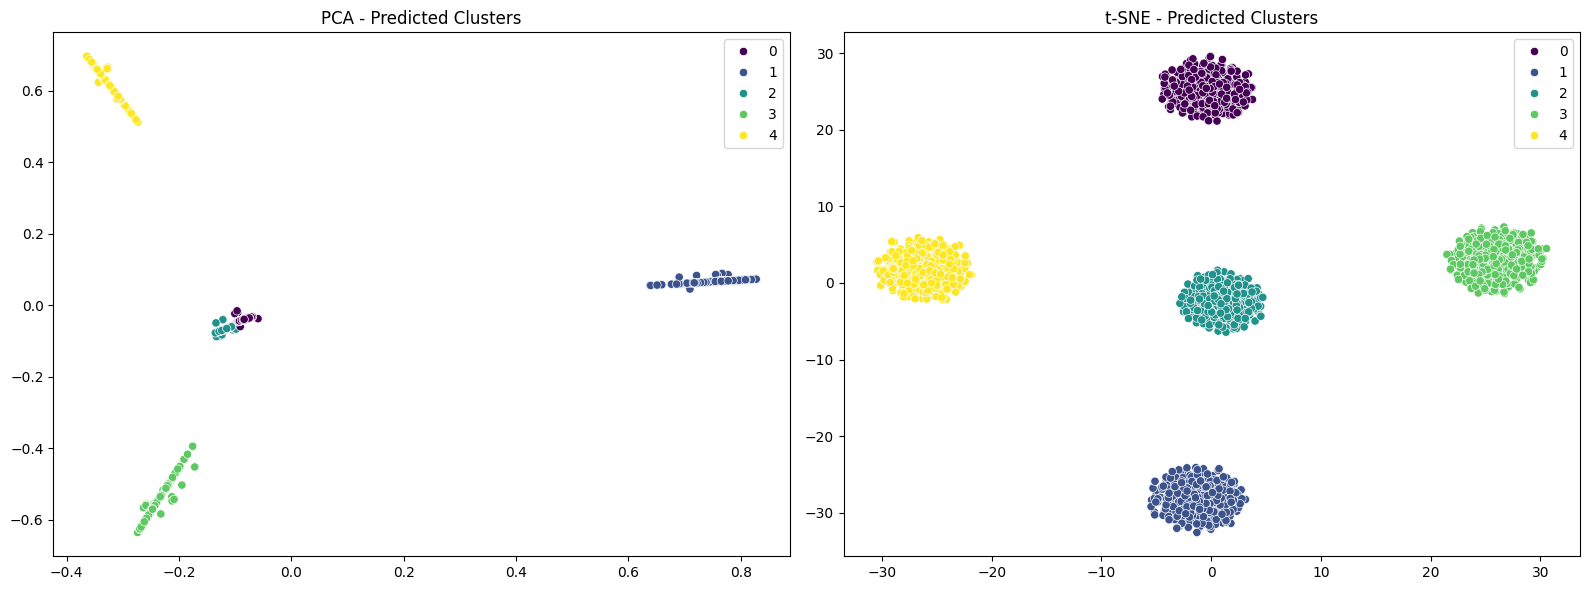


Analyzing clusters...

Classification Report (Clusters vs True Labels):
               precision    recall  f1-score   support

     business       1.00      1.00      1.00       400
entertainment       1.00      1.00      1.00       421
     politics       1.00      1.00      1.00       414
        sport       1.00      1.00      1.00       399
         tech       1.00      1.00      1.00       366

     accuracy                           1.00      2000
    macro avg       1.00      1.00      1.00      2000
 weighted avg       1.00      1.00      1.00      2000



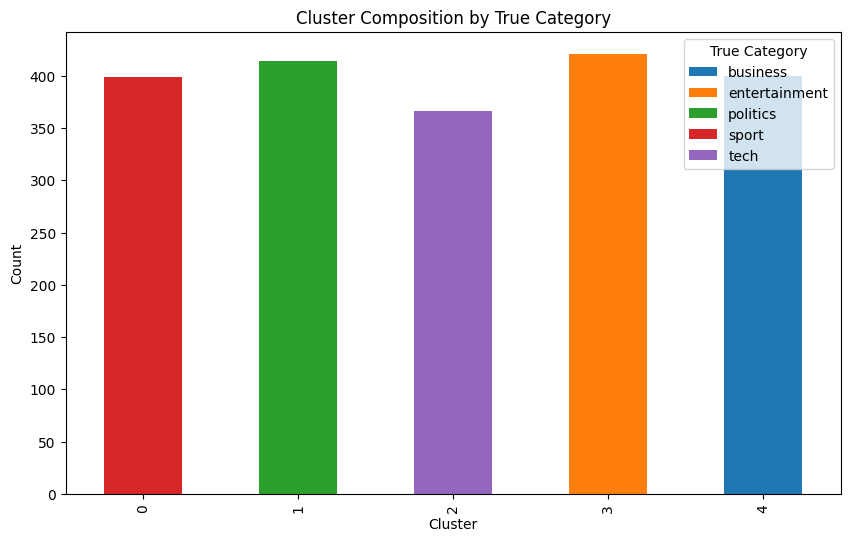


Top words per cluster:

Cluster 0:
tournament, goal, league, score, season, league goal, goal season, score season, goal score, score tournament

Cluster 1:
debate, parliament, law, agreement, international, law parliament, agreement international, parliament law, debate agreement, debate parliament

Cluster 2:
update, device, innovation, digital, technology, device update, update device, device device, digital update, innovation digital

Cluster 3:
release, director, album, actor, performance, release performance, release director, director album, actor release, release release

Cluster 4:
quarterly, investment, profit, growth, revenue, investment quarterly, profit quarterly, investment growth, quarterly investment, profit investment

Cluster to topic mapping:
Cluster 2: tech
Cluster 1: politics
Cluster 3: entertainment
Cluster 0: sport
Cluster 4: business

Results saved to /content/results/labeled_articles.csv


In [29]:
def main():
    # 1. Load your BBC dataset
    print("Loading data...")
    df = load_data()

    # 2. Preprocess and vectorize text
    print("Preprocessing text...")
    tfidf_matrix, vectorizer = tfidf_vectorize(df['text'])

    # 3. Perform clustering
    print("\nClustering with K-means...")
    kmeans_labels = cluster_kmeans(tfidf_matrix, df['category'])

    print("\nClustering with Hierarchical...")
    hierarchical_labels = cluster_hierarchical(tfidf_matrix, df['category'])

    # 4. Visualize results
    print("\nVisualizing results...")
    visualize_clusters(tfidf_matrix, kmeans_labels, df['category'])

    # 5. Analyze and label clusters
    print("\nAnalyzing clusters...")
    df_labeled, cluster_map = assign_topic_labels(df, kmeans_labels, vectorizer, tfidf_matrix)

    print("\nCluster to topic mapping:")
    for cluster, topic in cluster_map.items():
        print(f"Cluster {cluster}: {topic}")

    # Save results
    output_path = "/content/results/labeled_articles.csv"
    df_labeled.to_csv(output_path, index=False)
    print(f"\nResults saved to {output_path}")

if __name__ == "__main__":
    main()